In [1]:
%matplotlib inline
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
from CMS_Deep_Learning.storage.archiving import *
from CMS_Deep_Learning.layers.slice import Slice
from CMS_Deep_Learning.layers.lorentz import Lorentz
#from keras.utils.visualize_util import plot
from IPython.display import Image, display
from CMS_Deep_Learning.postprocessing.colors import colors_contrasting
from CMS_Deep_Learning.postprocessing.analysistools import *
from CMS_Deep_Learning.postprocessing.plot import *
from CMS_Deep_Learning.postprocessing.metrics import *
import numpy as np
archive_dir = "/data/shared/Delphes/keras_archive/"

#def sortTrialsOn(lst):
    

Using Theano backend.


In [2]:
trials = get_trials_by_name("LSTM", archive_dir)
#trials = findWithMetrics(trials, {"single_list" : False})
trials = [t for t in trials if t.is_complete()]
for trial in trials:
    trial.summary(showTraining=False,showValidation=False, showFit=False, showCompilation=False)
    #print(trial.get_history())
    #vp =  DataProcedure.from_json(archive_dir,trial.val_procedure[0])
    #data = vp.getData()[0]
    #for d in [x[0] for x in data]:
    #    print("Shape:", d.shape)
    #    print(d)
    #d0 = 
    #t = vp.kargs["single_list"] == True
    #trial.to_record({"single_list": t})
    #print(vp.func)
    #print(vp.kargs)
    #print(t)
print("TotalNumber of Trials:", len(trials)) 
#trials = get_trials_by_name("LSTM", archive_dir)
#trials = findWithMetrics(trials, {"single_list" : True})

--------------------------------------------------
TRIAL SUMMARY (5d52b075b9ba275c56a8e0d17599bbe77ce252f3)
    Record_Info:
        name = ["LSTM"], elapse_time = 2:33:18, last_epoch = 19, start_time = "02-28-2017 07:23:12 PST-PDT"
        val_acc = 0.8391
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "ttbar"], lstm_dropout = 0.0, num_val = 40000, output_activation = "softmax", patience = 8, query = null, single_list = true, sort_ascending = false, sort_on = "MaxLepKt"
--------------------------------------------------
--------------------------------------------------
TRIAL SUMMARY (d4dfa5a73b460443e75ac318702af45f57af857c)
    Record_Info:
        name = ["LSTM"], elapse_time = 4:39:24, last_epoch = 16, start_time = "02-26-2017 07:49:22 PST-PDT"
        val_acc = 0.8548
        num_train = 300000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "ttbar", "wjet"], lstm_dropout = 0.0, num_val = 60000, output_ac

In [3]:
print_by_labels(trials, 4)



 Classification: ('qcd', 'wjet') 'Top 4 trials'
--------------------------------------------------
TRIAL SUMMARY (b701497e5b5f3775951d0e8524263659f22d553c)
    Record_Info:
        name = ["LSTM"], elapse_time = 5:19:04, last_epoch = 28, start_time = "02-26-2017 20:17:50 PST-PDT"
        val_acc = 0.9949
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "wjet"], lstm_dropout = 0.0, num_val = 40000, output_activation = "softmax", patience = 8, query = null, single_list = true, sort_ascending = true, sort_on = "PT_ET"
--------------------------------------------------
--------------------------------------------------
TRIAL SUMMARY (683b78e7b026997e679d1a4c31f7ec2f84f272c2)
    Record_Info:
        name = ["LSTM"], elapse_time = 5:10:14, last_epoch = 27, start_time = "03-01-2017 04:57:36 PST-PDT"
        val_acc = 0.9939
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "wjet"], lstm_dropo

In [4]:
#trial = KerasTrial.find_by_hashcode(archive_dir,"d2fd2c62cbe832d33fbe1a0f313850836f76bbc5")

#tr =TrialIterator(trial, return_X=False, return_Y=True,return_prediction=True)
#y,predictions = tr.asList()

DataProcedure results 'c8f4291c38002b369015ab9541a80aec1ea8b62a' read from archive
DataProcedure results 'c8f4291c38002b369015ab9541a80aec1ea8b62a' read from archive
(2052, None)
DataProcedure results 'ccf2c75d699b17e8b7dd3377354d5a36bee0941c' read from archive
(4104, None)
DataProcedure results '495693ce6b487e0471da35533593fbfb73a04b5a' read from archive
(6156, None)
DataProcedure results '6a7238c59864bf76d1bee31d5335f7af67c8bbfd' read from archive
(8208, None)
DataProcedure results '89725788466375bd6dedfeb3e8b4254b21705cd5' read from archive
(10260, None)
DataProcedure results 'b033ce05aa808dfb58e62676a29b5aa7834a777d' read from archive
(12312, None)
DataProcedure results 'b41c62911c7d72a4e5e74818501b22db11f02ca6' read from archive
(14364, None)
DataProcedure results '313b6df086155f44835db48385028d97a7ad4336' read from archive
(16416, None)
DataProcedure results 'c4e2659539ed20c33142121f2eec306f94b90bbd' read from archive
(18468, None)
DataProcedure results '7683dcd11f494295fdd86c39f

In [2]:
best_qcd_wjet =  KerasTrial.find_by_hashcode(archive_dir,"b701497e5b5f3775951d0e8524263659f22d553c")
best_ttbar_wjet =  KerasTrial.find_by_hashcode(archive_dir,"73f08cfb0545edb69ab086bfc0087d181034e0c5")
best_qcd_ttbar =  KerasTrial.find_by_hashcode(archive_dir,"d2fd2c62cbe832d33fbe1a0f313850836f76bbc5")
best_qcd_ttbar_wjet =  KerasTrial.find_by_hashcode(archive_dir,"9c00977ef8e932f946f10318a3f1e30f84ecb2b0")

DataProcedure results 'ee9dd35a906860062672731b1f39577ba3d278fa' read from archive
DataProcedure results 'ee9dd35a906860062672731b1f39577ba3d278fa' read from archive
(2052, None)
DataProcedure results 'aa037d647acddd5622c05d952a5771a379174a8e' read from archive
(4104, None)
DataProcedure results 'c04fd3ddf832dd5993c54349b5c58ba4918dbf1e' read from archive
(6156, None)
DataProcedure results 'fd4b2a783639dc6631246694c9d33c47e0f6781a' read from archive
(8208, None)
DataProcedure results '32edbb5a1302d135631d8b5dbb992f5afa079fe4' read from archive
(10260, None)
DataProcedure results 'a3927860b7440cfcbd0ce480a3ba39d068c7e822' read from archive
(12312, None)
DataProcedure results '897525a7f2a5cba5b470569fa2af6d429f1392df' read from archive
(14364, None)
DataProcedure results 'c6cd65e710755225aa071659aaae2633340d97c1' read from archive
(16416, None)
DataProcedure results '855ab5980475e44d22fef2773f31b95a3009f66c' read from archive
(18468, None)
DataProcedure results '0e60c3c21e99f7c6d61e13206

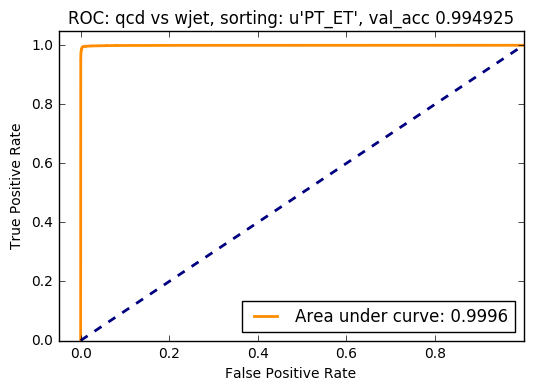

DataProcedure results '14db18e8c49ebdd8c7675a141eb45caa97bd87aa' read from archive
DataProcedure results '14db18e8c49ebdd8c7675a141eb45caa97bd87aa' read from archive
(2052, None)
DataProcedure results '0fde139bbc43c56aae961aa2d4a1aabeaca8c59f' read from archive
(4104, None)
DataProcedure results '31de5f074b19da151180333abdd4bd4ccfff773d' read from archive
(6156, None)
DataProcedure results 'dfd5b5c54c11d3375a9a6cd3d3b1685c25323bc9' read from archive
(8208, None)
DataProcedure results '8b0d721c0ca9483130e389b7a4faf727cd1b5511' read from archive
(10260, None)
DataProcedure results '75c72a0100a06f2336d16ba7d1f2ed6e15219543' read from archive
(12312, None)
DataProcedure results '56386ca324cd4333a99cfdbc48b496c601765e6d' read from archive
(14364, None)
DataProcedure results 'f13e3d2eb5872fdb4b0e8a55745d726063dd15e8' read from archive
(16416, None)
DataProcedure results '5c2969d68e10fbde0223b913c0da2365d40133ae' read from archive
(18468, None)
DataProcedure results 'e4779354cf714f33e994c762b

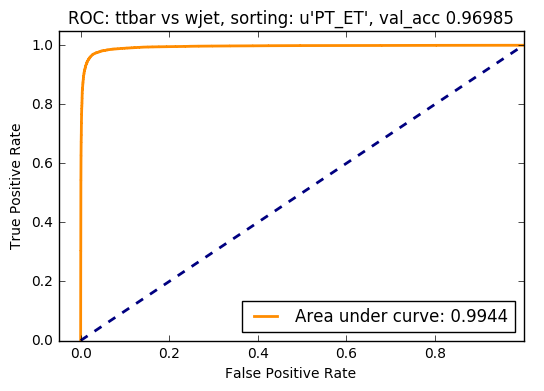

DataProcedure results 'c8f4291c38002b369015ab9541a80aec1ea8b62a' read from archive
DataProcedure results 'c8f4291c38002b369015ab9541a80aec1ea8b62a' read from archive
(2052, None)
DataProcedure results 'ccf2c75d699b17e8b7dd3377354d5a36bee0941c' read from archive
(4104, None)
DataProcedure results '495693ce6b487e0471da35533593fbfb73a04b5a' read from archive
(6156, None)
DataProcedure results '6a7238c59864bf76d1bee31d5335f7af67c8bbfd' read from archive
(8208, None)
DataProcedure results '89725788466375bd6dedfeb3e8b4254b21705cd5' read from archive
(10260, None)
DataProcedure results 'b033ce05aa808dfb58e62676a29b5aa7834a777d' read from archive
(12312, None)
DataProcedure results 'b41c62911c7d72a4e5e74818501b22db11f02ca6' read from archive
(14364, None)
DataProcedure results '313b6df086155f44835db48385028d97a7ad4336' read from archive
(16416, None)
DataProcedure results 'c4e2659539ed20c33142121f2eec306f94b90bbd' read from archive
(18468, None)
DataProcedure results '7683dcd11f494295fdd86c39f

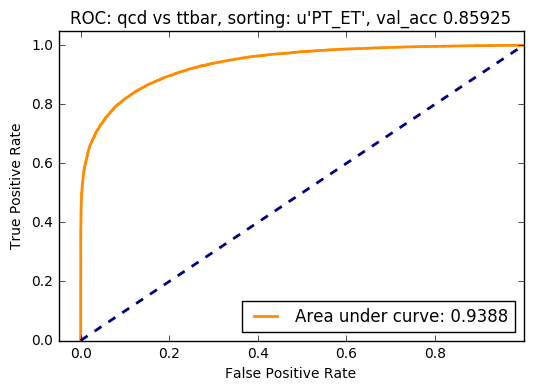

DataProcedure results '514d7de178831b09ff5e4e2220422fe6b6c9a9d9' read from archive
DataProcedure results '514d7de178831b09ff5e4e2220422fe6b6c9a9d9' read from archive
(3078, None)
DataProcedure results '2f6141d869c14b825765f2aa0f7a28c9e384d86b' read from archive
(6156, None)
DataProcedure results '188b626236b1ec1350ba001af4d3ae9b665d2c81' read from archive
(9234, None)
DataProcedure results '0fd6b5dc70ccc44c99f2d994971d0a17bf791c58' read from archive
(12312, None)
DataProcedure results '1a4f9f3f73410125c1b97dbd873960b1cd387823' read from archive
(15390, None)
DataProcedure results 'ac5e53e6fc2f5a91644672942513c69d824843b7' read from archive
(18468, None)
DataProcedure results '864692d716fbc31268a122045201e4ca34594599' read from archive
(21546, None)
DataProcedure results '7ef6565f24ca14d796bd6411b2a95ba4fe5e60bf' read from archive
(24624, None)
DataProcedure results '4a67e9040ef0841741b3776f3a11db03582b3ef1' read from archive
(27702, None)
DataProcedure results '36cf8456862de2a8928d9855

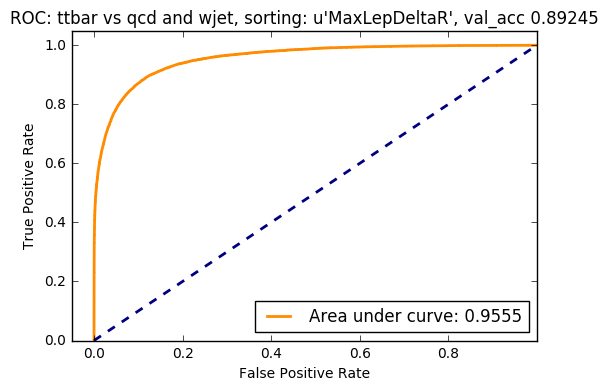

DataProcedure results '514d7de178831b09ff5e4e2220422fe6b6c9a9d9' read from archive
DataProcedure results '514d7de178831b09ff5e4e2220422fe6b6c9a9d9' read from archive
(3078, None)
DataProcedure results '2f6141d869c14b825765f2aa0f7a28c9e384d86b' read from archive
(6156, None)
DataProcedure results '188b626236b1ec1350ba001af4d3ae9b665d2c81' read from archive
(9234, None)
DataProcedure results '0fd6b5dc70ccc44c99f2d994971d0a17bf791c58' read from archive
(12312, None)
DataProcedure results '1a4f9f3f73410125c1b97dbd873960b1cd387823' read from archive
(15390, None)
DataProcedure results 'ac5e53e6fc2f5a91644672942513c69d824843b7' read from archive
(18468, None)
DataProcedure results '864692d716fbc31268a122045201e4ca34594599' read from archive
(21546, None)
DataProcedure results '7ef6565f24ca14d796bd6411b2a95ba4fe5e60bf' read from archive
(24624, None)
DataProcedure results '4a67e9040ef0841741b3776f3a11db03582b3ef1' read from archive
(27702, None)
DataProcedure results '36cf8456862de2a8928d9855

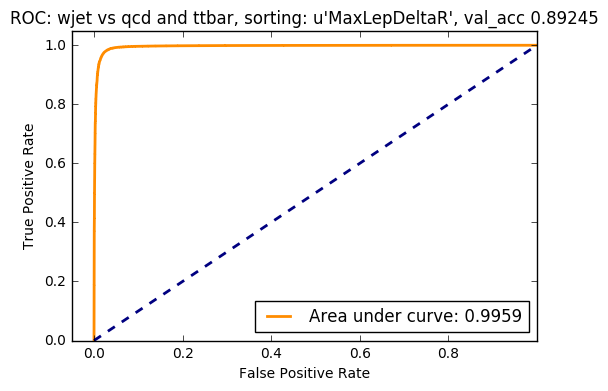

In [4]:
from sklearn.metrics import roc_curve,auc
def draw_roc_curve(trial=None, labels=None,predictions=None, true_index=None, title="ROC Curve"):
    if(trial != None):
        tr =TrialIterator(trial, return_X=False, return_Y=True,return_prediction=True)
        labels,predictions = tr.asList()
        labels = labels[0]
        
    labels = np.array(labels)
    predictions = np.array(predictions)
    # Draw the ROC curve
    labels = np.array(labels)
    predictions = np.array(predictions)
   
    assert labels.shape == predictions.shape, "labels and predictions should have \
        the same shape, %r != %r" % (labels.shape == predictions.shape)
    n = labels.shape[0]
    if(len(labels.shape) > 1 and labels.shape[1] > 1):
        if(true_index != None):
            labels = labels[:, true_index].ravel()
            predictions = predictions[:, true_index].ravel()
        else:
            raise ValueError("must designate index of true class for data of shape %r" % list(labels.shape))
            
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', \
             lw=lw, label='Area under curve: %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
   
    #plt.xlim([.0, 1.01])
    #plt.ylim([.0, 1.01])
    #plt.title("ROC Curve")
    #plt.plot( tpr, fpr )d2fd2c62cbe832d33fbe1a0f313850836f76bbc5

draw_roc_curve(best_qcd_wjet,true_index=1, title="ROC: qcd vs wjet, sorting: %r, val_acc %r" \
               % tuple(best_qcd_wjet.get_from_record(["sort_on", "val_acc"])))



draw_roc_curve(best_ttbar_wjet,true_index=0, title="ROC: ttbar vs wjet, sorting: %r, val_acc %r" \
               % tuple(best_ttbar_wjet.get_from_record(["sort_on", "val_acc"])))


draw_roc_curve(best_qcd_ttbar,true_index=1, title="ROC: qcd vs ttbar, sorting: %r, val_acc %r" \
               % tuple(best_qcd_ttbar.get_from_record(["sort_on", "val_acc"])))


draw_roc_curve(best_qcd_ttbar_wjet,true_index=1, title="ROC: ttbar vs qcd and wjet, sorting: %r, val_acc %r" \
               % tuple(best_qcd_ttbar_wjet.get_from_record(["sort_on", "val_acc"])))
draw_roc_curve(best_qcd_ttbar_wjet,true_index=2, title="ROC: wjet vs qcd and ttbar, sorting: %r, val_acc %r" \
               % tuple(best_qcd_ttbar_wjet.get_from_record(["sort_on", "val_acc"])))
    
#for z,p in zip(tpr, fpr):
#    print(z,p)
    
    

In [8]:
!pip install pyparsing==1.5.7
!pip install pydot==1.0.28
!pip install graphviz

--------------------------------------------------
TRIAL SUMMARY (b701497e5b5f3775951d0e8524263659f22d553c)
    Record_Info:
        name = ["LSTM"], elapse_time = 5:19:04, last_epoch = 28, start_time = "02-26-2017 20:17:50 PST-PDT"
        val_acc = 0.9949
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "wjet"], lstm_dropout = 0.0, num_val = 40000, output_activation = "softmax", patience = 8, query = null, single_list = true, sort_ascending = true, sort_on = "PT_ET"
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


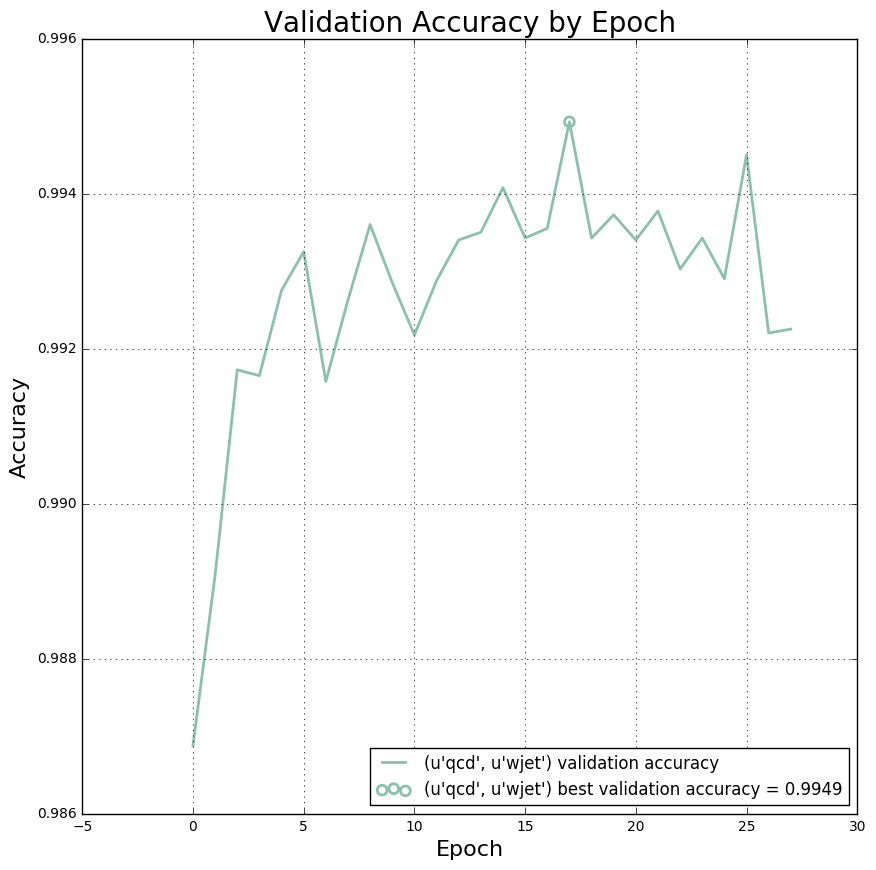

--------------------------------------------------
TRIAL SUMMARY (73f08cfb0545edb69ab086bfc0087d181034e0c5)
    Record_Info:
        name = ["LSTM"], elapse_time = 4:57:16, last_epoch = 30, start_time = "02-27-2017 01:38:57 PST-PDT"
        val_acc = 0.9698
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["ttbar", "wjet"], lstm_dropout = 0.0, num_val = 40000, output_activation = "softmax", patience = 8, query = null, single_list = true, sort_ascending = true, sort_on = "PT_ET"
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


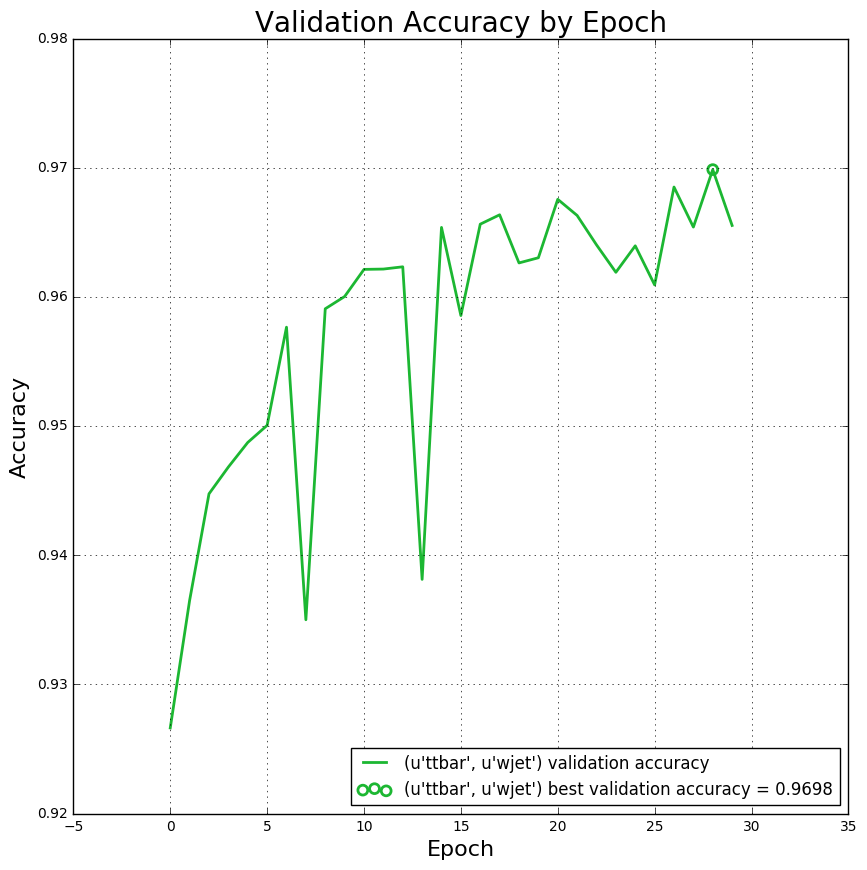

--------------------------------------------------
TRIAL SUMMARY (d2fd2c62cbe832d33fbe1a0f313850836f76bbc5)
    Record_Info:
        name = ["LSTM"], elapse_time = 7:42:25, last_epoch = 30, start_time = "02-26-2017 12:32:42 PST-PDT"
        val_acc = 0.8592
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "ttbar"], lstm_dropout = 0.0, num_val = 40000, output_activation = "softmax", patience = 8, query = null, single_list = true, sort_ascending = true, sort_on = "PT_ET"
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


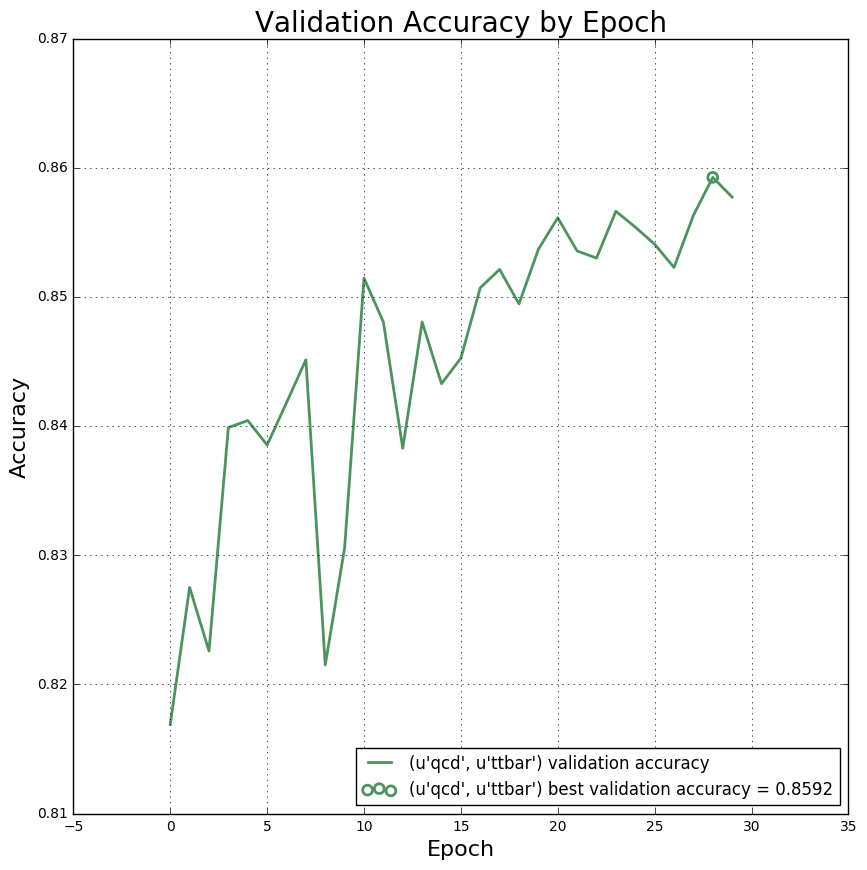

--------------------------------------------------
TRIAL SUMMARY (9c00977ef8e932f946f10318a3f1e30f84ecb2b0)
    Record_Info:
        name = ["LSTM"], elapse_time = 7:13:51, last_epoch = 30, start_time = "02-28-2017 00:06:57 PST-PDT"
        val_acc = 0.8924
        num_train = 300000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "ttbar", "wjet"], lstm_dropout = 0.0, num_val = 60000, output_activation = "softmax", patience = 8, query = null, single_list = true, sort_ascending = false, sort_on = "MaxLepDeltaR"
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


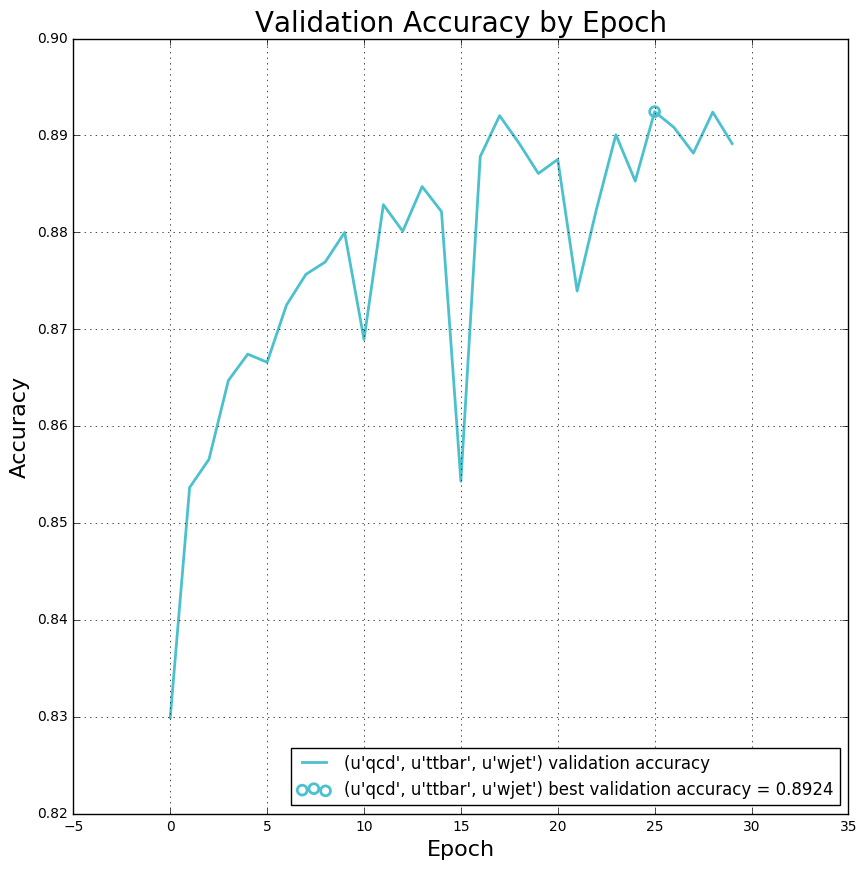

In [3]:
#import pydot
#print(pydot.__version__)
plotEverything(best_qcd_wjet)
plotEverything(best_ttbar_wjet)
plotEverything(best_qcd_ttbar)
plotEverything(best_qcd_ttbar_wjet)

In [87]:
#from CMS_Deep_Learning.storage.archiving import find_by_hashcode
trial = KerasTrial.find_by_hashcode(archive_dir,"d93e69176caef48cd3f187e137fb03c305b5f156")
trial.summary()
#trials = findWithMetrics(trials, {"single_list" : True})
tr =TrialIterator(trial, return_X=True, return_Y=True)
tr_single = tr.asList()

trial = KerasTrial.find_by_hashcode(archive_dir,"1bea8d9f9edd7911ed0b194862a0684693c5af1f")
trial.summary()
#trials = get_trials_by_name("LSTM", archive_dir)
#trials = findWithMetrics(trials, {"single_list" : False})
tr =TrialIterator(trial, return_X=True, return_Y=True)
tr_not = tr.asList()


AttributeError: 'NoneType' object has no attribute 'summary'

In [43]:
np.set_printoptions(threshold='nan')
print(tr_single[0][0][0])
print("Multi")
for x in tr_not[0]:
    print("")
    print(len(x[0]))
    print(x[0])
#print([len(x[0]) for x in tr_not[0]])

[[  1.60715463e+02  -1.28822196e+01   2.14808819e+01   1.58751630e+02
    2.50475521e+01   2.54587817e+00   2.11099982e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   1.04478998e+01  -1.67793698e-12
    0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.00000000e+00
    9.15675143e-03   5.35937586e-03   1.79858028e-02   1.00000000e+00]
 [  1.01806505e+03  -1.15896376e+01  -2.16563685e+01   1.01776870e+03
    2.45625324e+01   4.41743851e+00  -2.06217527e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   4.00000000e+00]
 [  4.29083788e+01   7.42874199e+00  -1.47639727e+01   3.95975741e+01
    1.65275860e+01   1.60783958e+00  -1.10461843e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   4.29083786e+01   0.00000000e+00   0.00000000e+00
    7.80839404e-03

In [58]:
print_by_labels(trials, 4)



 Classification: ('ttbar', 'wjet') 'Top 4 trials'
--------------------------------------------------
TRIAL SUMMARY (94c489b8384189006727fd44f7d5ae72d864f2b5)
    Record_Info:
        name = ["LSTM"], elapse_time = 3:45:43, last_epoch = 26, start_time = "02-25-2017 06:33:22 PST-PDT"
        val_acc = 0.9677
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["ttbar", "wjet"], lstm_dropout = 0.0, num_val = 40000, output_activation = "softmax", patience = 8, query = null, single_list = false, sort_ascending = false, sort_on = "MaxLepDeltaEta"
--------------------------------------------------
--------------------------------------------------
TRIAL SUMMARY (84b962d7e222f4b752d795c6640956ec10b87e12)
    Record_Info:
        name = ["LSTM"], elapse_time = 4:06:48, last_epoch = 30, start_time = "02-23-2017 17:41:05 PST-PDT"
        val_acc = 0.9674
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["ttbar", "w

In [4]:
#import sklearn

trial = trials[0]

observable_ordering=['E/c', 'Px', 'Py', 'Pz', 'PT_ET','Eta', 'Phi', 'Charge', 'X', 'Y', 'Z', 
                     'Dxy', 'Ehad', 'Eem', 'MuIso', 'EleIso', 'ChHadIso','NeuHadIso','GammaIso']
object_ordering=["Electron", "MuonTight", "MissingET","EFlowPhoton", "EFlowNeutralHadron", "EFlowTrack"]

#=d = accVsEventChar(trial, None, np.sum, "PT_ET", objects=["EFlowPhoton","EFlowNeutralHadron","EFlowTrack"], 
#                       observable_ordering=observable_ordering,object_ordering=object_ordering,
#                       bins=20,custom_objects={"Slice": Slice, "Lorentz": Lorentz},equalBins=False)
d = accVsEventChar(trial, None, np.sum, "PT_ET", objects=["EFlowPhoton","EFlowNeutralHadron","EFlowTrack"],
                       observable_ordering=observable_ordering,object_ordering=object_ordering,
                       bins=20,custom_objects={"Slice": Slice, "Lorentz": Lorentz},equalBins=False, plot=True)
#assert set([t for t in d.items()]) == set([t for t in d2.items()])
#def plot_ROC(trial):
#    X,Y = 
#    sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

DataProcedure results 'ea70748b0ba03c0e745781b3cab5b3ef58d8c186' read from archive
DataProcedure results 'ea70748b0ba03c0e745781b3cab5b3ef58d8c186' read from archive


IndexError: list index out of range

In [55]:
#trials = findWithMetrics(trials, {"useObjTypeColumn" : True})
print_by_labels(trials, 4)

#plot_history([("Fully connected:", trials[0].get_history())], plotLoss=False)




 Classification: ('qcd', 'wjet') 'Top 4 trials'
--------------------------------------------------
TRIAL SUMMARY (158aa6b5e8cbf3b7ee3e5f7903b481a7890c7801)
    Record_Info:
        name = ["LSTM"], elapse_time = 4:13:18, last_epoch = 30, start_time = "02-24-2017 07:15:41 PST-PDT"
        val_acc = 0.9911
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "wjet"], lstm_dropout = 0.0, num_val = 40000, output_activation = "softmax", patience = 8, query = null, single_list = true, sort_ascending = false, sort_on = "MaxLepDeltaEta"
--------------------------------------------------
--------------------------------------------------
TRIAL SUMMARY (a2b4e04bbb827b1d234063d8849799463e4dab5c)
    Record_Info:
        name = ["LSTM"], elapse_time = 2:44:09, last_epoch = 21, start_time = "02-22-2017 20:31:35 PST-PDT"
        val_acc = 0.9894
        num_train = 200000
        activation = "tanh", depth = 1, dropout = 0.0, labels = ["qcd", "wjet"], 

In [ ]:
t = findWithMetrics(trials, {"labels" : [u'ttbar', u'wjet', u'qcd'], 'sort_on' : "Phi"})
t[0].summary(showCompilation=True, showFit=True)

In [4]:
plotEverything(trials)
    
    


RuntimeError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [5]:
def print_by_labels(trials, num_print=None, sortMetric='val_acc'):
    '''Prints trials ordered and grouped by their labeles
        #Arguments:
            trials -- A list of KerasTrials
            num_print -- How many to print, Defaults is all of them.
            sortMetric -- What metric to sort the trials on
    '''
    trials_by_set = group_by_labels(trials)
    for classification in trials_by_set:
        lst = trials_by_set[classification]
        head_str = "\n\n Classification: %r %r" % (classification,
                                                   "Top %r trials" % num_print if num_print != None else "")
        print(head_str)
        sortOnMetric(lst, sortMetric=sortMetric)
        if (num_print == None): num_print = len(lst)
        for i in range(min(num_print, len(lst))):
            lst[i].summary(showTraining=False, showValidation=False, showFit=False, showCompilation=True)

In [13]:
no_single = findWithMetrics(trials,{"single_list" : False,"optimizer" : "adam"})
print(len(no_single))
phi = findWithMetrics(no_single,{"sort_on" : "Phi"})
eta = findWithMetrics(no_single,{"sort_on" : "Eta"})
PT_as = findWithMetrics(no_single,{"sort_on" : "PT_ET", "sort_ascending" : True})
PT_de = findWithMetrics(no_single,{"sort_on" : "PT_ET", "sort_ascending" : False})
#[t.summary(showCompilation=True) for t in phi]
print_by_labels(phi, 4)
print_by_labels(eta, 4)
print(len(phi), len(eta), len(PT_as), len(PT_de))
sortOnMetric(phi, "labels")
sortOnMetric(eta, "labels")
sortOnMetric(PT_as, "labels")
sortOnMetric(PT_de, "labels")
labelGroups = zip(phi,eta,PT_as,PT_de)

0
(0, 0, 0, 0)


7


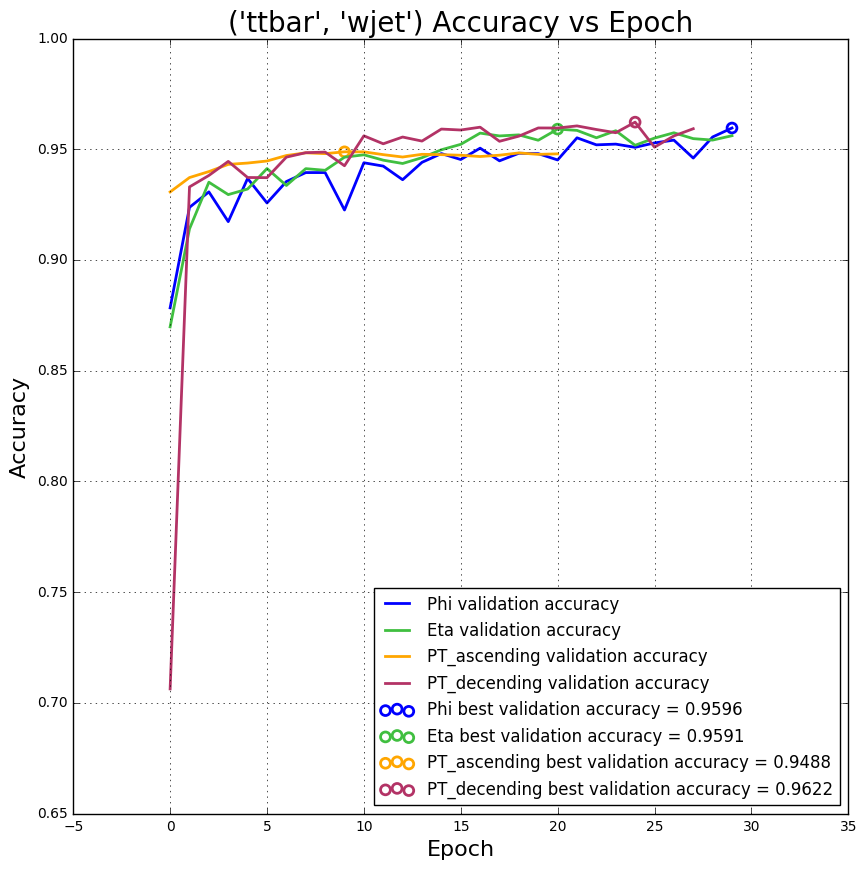

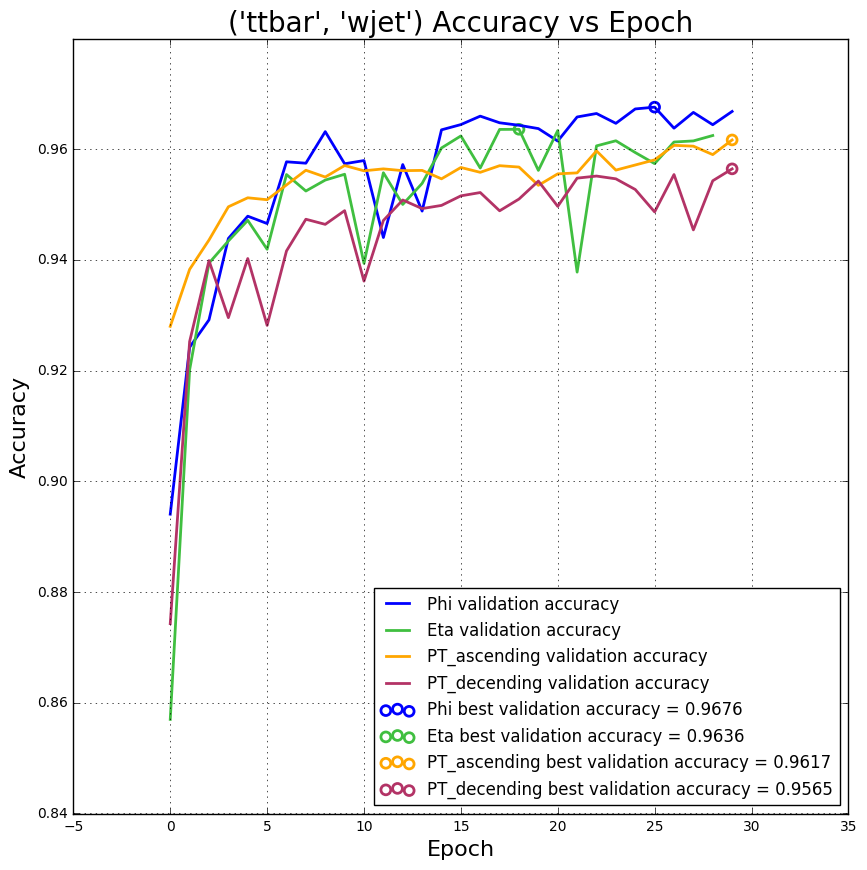

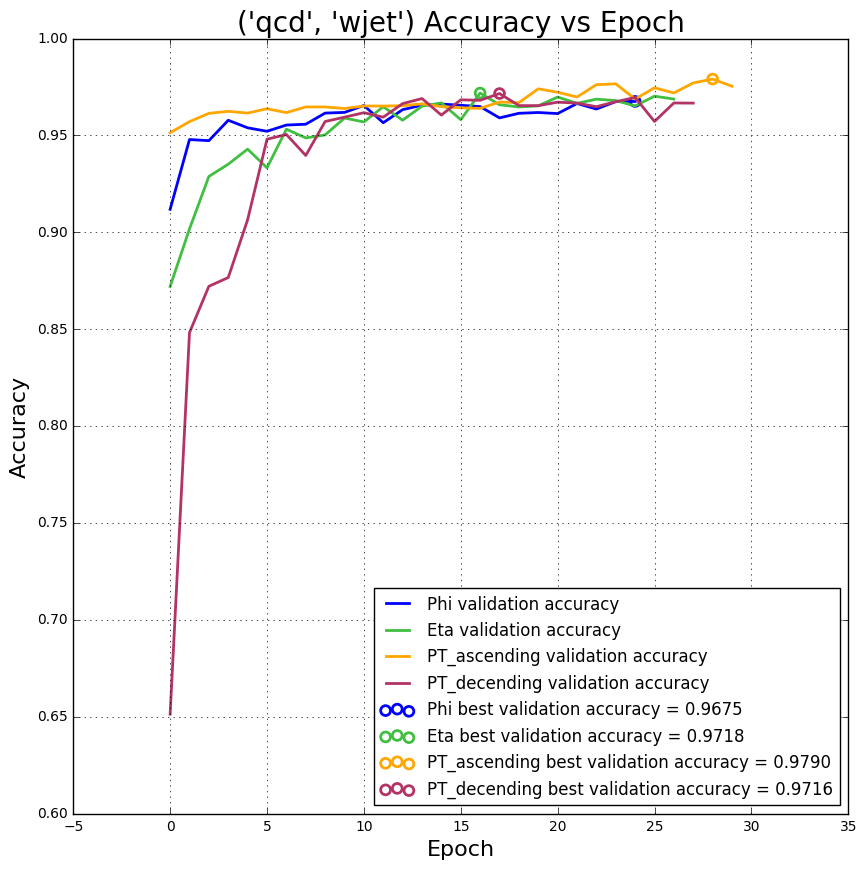

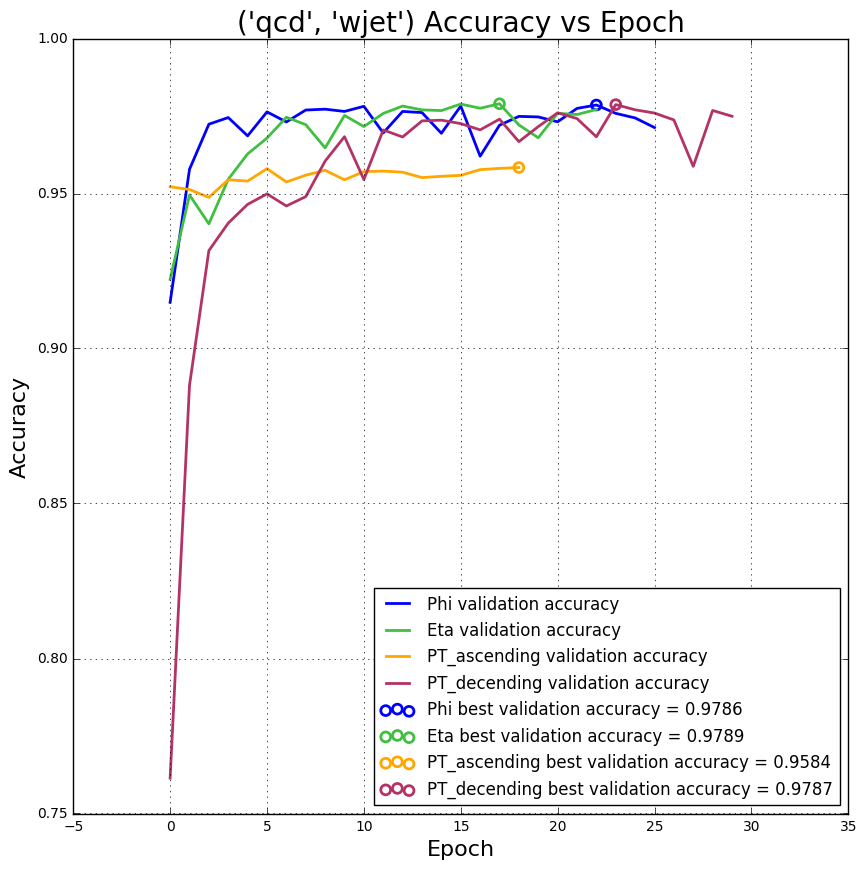

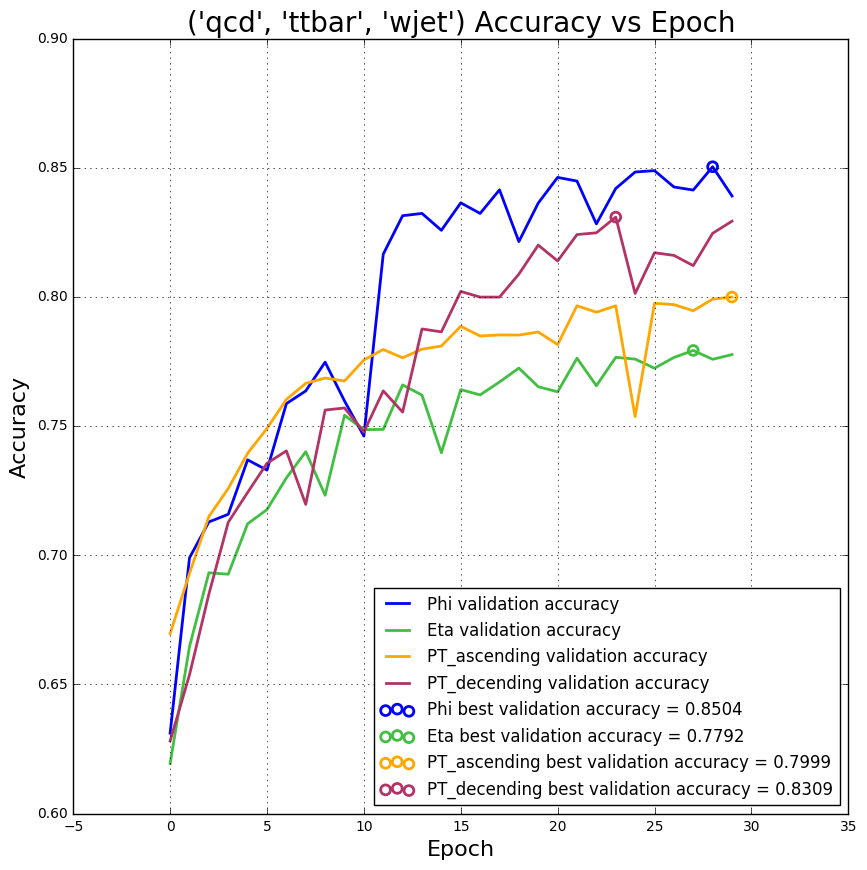

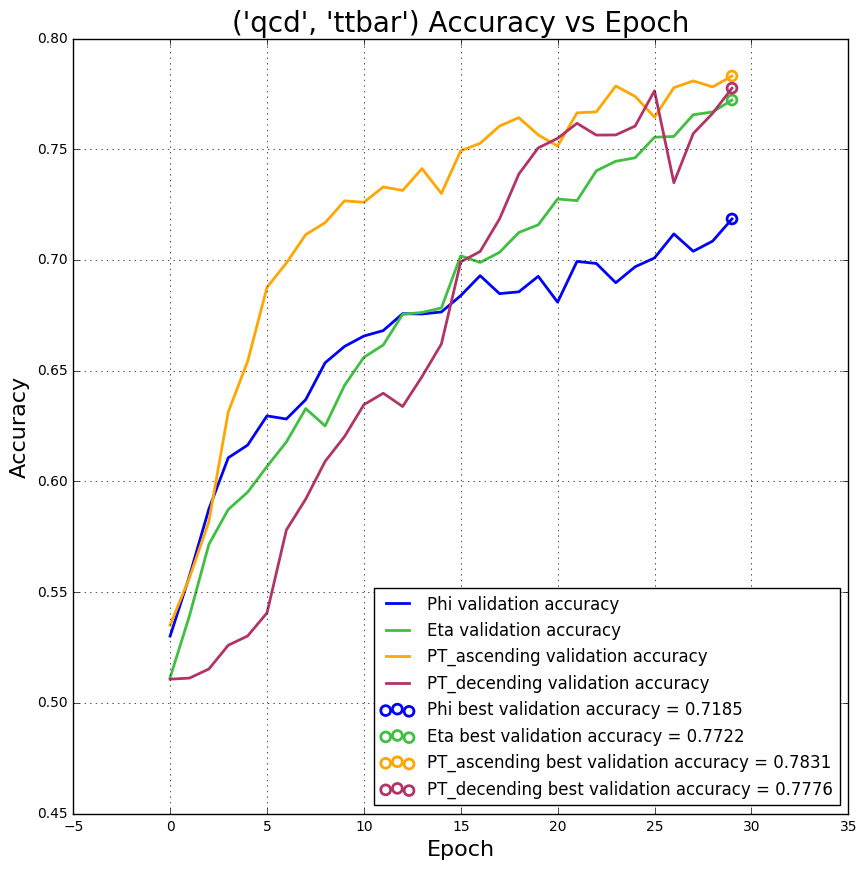

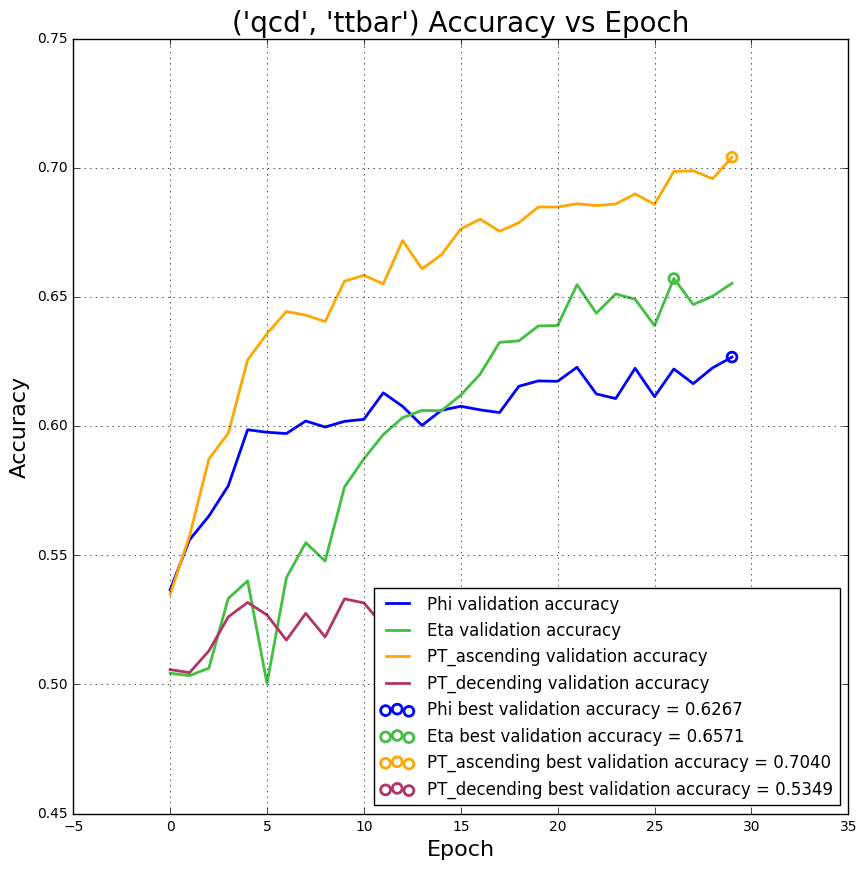

In [7]:
colors = [(0,0,1.0),(.25,.75,.25), (1,.65,0), (.7,.2,.4)]
names = ["Phi", "Eta","PT_ascending", "PT_decending"]
#lims = [[.7,.91], [.8,1.0],  [.8,1.0],  [.4,.82]]
print(len(labelGroups))
for j , tup in enumerate(labelGroups):
    plots = []
    for i, b in enumerate(tup):
        labels = b.get_from_record("labels")
        if(labels == None): labels = b.get_from_record("lables")
        title = str(tuple([str(x) for x in labels])) if(labels != None) else "Cannot Find Labels"
        title = title + " Accuracy vs Epoch"
        name = names[i]
        model = b.get_model(custom_objects={"Slice":Slice, "Lorentz" : Lorentz})
        history = b.get_history()
        color = colors[i]
        plots.append((name, history, color))
    plot_history(plots, plotLoss=False, title=title)#, acclims=lims[j])
    
    

In [ ]:
data = np.zeros(( len(labelGroups[0]),len(labelGroups) ) ).tolist()
print(data)
columns = [None] * len(labelGroups)
rows = [" "+ n + " " for n in names]

for j , tup in enumerate(labelGroups):
    for i, b in enumerate(tup):
        labels = b.get_from_record("labels")
        columns[j] = str(tuple([str(x) for x in labels]))
        error = getError(b,custom_objects={"Slice":Slice, "Lorentz" : Lorentz}, ignoreAssert=True)
        d = "%.5f %s %.5f" % (b.get_from_record("val_acc"),unichr(177), error)
        data[i][j] = d
        
        
#print(data)
        

In [ ]:
plotTable(rows, columns, data,scale=2, title="Validation Accuracy for LSTM Trials by Classification and Sorting")

In [ ]:
def getTrialBins(trial, bins=20):
    trial.summary()
    d = accVsEventChar(trial, None, np.sum, "PT_ET", ["EFlowPhoton","EFlowNeutralHadron","EFlowTrack"],
                       bins=bins,custom_objects={"Slice": Slice, "Lorentz": Lorentz},equalBins=False)
    #plotBins(d,title='Accuracy vs Sum of PF Candidate PT', xlabel="PT GeV", ylabel='Accuracy', color=(0.553,0.188,0.38))
    return d
eta_bins = [getTrialBins(t,40) for t in eta]
phi_bins = [getTrialBins(t,40) for t in phi]

In [ ]:
colors = [(0,0,1.0),(.25,.75,.25), (1,0,0), (1,.65,0)]
lables = [trial.get_from_record("labels") for trial in eta]
plotBins(eta_bins,mode="scatter",title='Eta-LSTM: Accuracy vs Sum of PF Candidate PT',binLabels=lables, xlabel="PT GeV", ylabel='Accuracy',
         legendTitle="Classification",colors=colors, alpha=.2, ylim=(0.75, 1.025), xlim=(0,3000))

lables = [trial.get_from_record("labels") for trial in phi]
plotBins(phi_bins,mode="scatter",title='Phi-LSTM: Accuracy vs Sum of PF Candidate PT',binLabels=lables, xlabel="PT GeV", ylabel='Accuracy',
         legendTitle="Classification",legendBelow=True,colors=colors, alpha=.4, ylim=(0.75, 1.025), xlim=(0,3000))

In [ ]:
import sys
import numpy as np
from CMS_Deep_Learning.storage.archiving import DataProcedure
if(sys.version_info[0] > 2):
    from inspect import signature
    getNumParams = lambda f: len(signature(f).parameters)
else:
    from inspect import getargspec
    getNumParams = lambda f: len(getargspec(f)[0])


class DataIterator:
    def __init__(self, proc, num_samples=None, return_X=False, return_Y=True, accumilate=None, prediction_model=None):
        if (isinstance(proc, list)):
            first_data = proc[0].getData()
        else:
            first_data = proc.getData()
        if (isinstance(first_data, types.GeneratorType)):
            proc = first_data

        self.proc = proc
        self.num_samples = num_samples
        self.accumilate = accumilate
        self.prediction_model = prediction_model
        self.return_X = return_X
        self.return_Y = return_Y
        if (isinstance(proc, list)):
            if (False in [isinstance(p, DataProcedure) for p in proc]):
                raise ValueError("procedure list must contain only DataProcedures")
            # self.next = _listNext
            self.proc_itr = iter(self.proc)
            self.mode = "list"
        elif (isinstance(proc, types.GeneratorType)):
            if (num_samples == None):
                raise ValueError("num_samples must be passed along with procedure generator.")
            # self.next = _genNext
            self.mode = "generator"
        else:
            raise ValueError("Bad input.")
            # initialize(proc, num_samples=num_samples, accumilate=accumilate, prediction_model=prediction_model)

    def getLength(self):
        if (self.num_samples == None):
            num_samples = 0
            for p in self.proc:
                if (isinstance(p, DataProcedure)):
                    X, Y = p.getData()
                else:
                    X, Y = p
                if (not isinstance(Y, list)): Y = [Y]
                num_samples += Y[0].shape[0]
            self.num_samples = num_samples
        return self.num_samples

    def asList(self):
        if (self.accumilate != None): num_params  =getNumParams(self.accumilate)
        X_out = None
        Y_out = None
        pred_out = None
        acc_out = None
        pos = 0
        for p in self.proc:
            X, Y = p.getData()

            if (not isinstance(Y, list)): Y = [Y]
            L = Y[0].shape[0]

            if (not isinstance(X, list)): X = [X]
            if (self.return_X):
                if (X_out == None): X_out = [[None] * self.getLength() for i in range(len(X))]
                # print([len(x) for x in X_out])
                # print([len(x) for x in X])
                for i, x in enumerate(X):
                    Xi_out = X_out[i]
                    # print(len(xi))
                    for j in range(L):
                        Xi_out[pos + j] = x[j]

            if (self.return_Y):
                if (Y_out == None): Y_out = [[None] * self.getLength() for i in range(len(Y))]
                for i, y in enumerate(Y):
                    Yi_out = Y_out[i]
                    for j in range(L):
                        Yi_out[pos + j] = y[j]

            if (self.prediction_model != None):
                if (pred_out == None): pred_out = [None] * self.getLength()
                pred = self.prediction_model.predict_on_batch(X)
                for j in range(L):
                    pred_out[pos + j] = pred[j]

            if (self.accumilate != None):
                if (acc_out == None): acc_out = [None] * self.getLength()
                if(num_params == 1):
                    acc = self.accumilate(X)
                else:
                    acc = self.accumilate(X,Y)
                for j in range(L):
                    acc_out[pos + j] = acc[j]
                    print(len(acc_out),pos + j)

            pos += L
            print(pos, self.accumilate)  # ,acc_out))
        out = []
        if (X_out != None):
            for i, xo in enumerate(X_out):
                X_out[i] = np.array(xo)
            out.append(X_out)
        if (Y_out != None):
            for i, yo in enumerate(Y_out):
                Y_out[i] = np.array(yo)
            out.append(Y_out)
        if (pred_out != None):
            out.append(np.array(pred_out))
        if (acc_out != None):
            out.append(np.array(acc_out))
        return out

    # def _genNext():
    #    #N = num_samples/ba
    #    data = data.getData()
    #    for i in range(self.num_samples)
    #        yield next(data)
    #    return StopIteration()
    '''
    def _listNext():
        for p in self.proc:
            X,Y = p.getData()
            pred = self.prediction_model.predict_on_batch(X) if self.prediction_model != None else None
            acc = self.accumilate(X) if self.accumilate != None else None
            for  in
                yield next(self.proc)
        return StopIteration()
    '''

    def __iter__(self):
        return self

        # def next(self):
        #    self.count += 1
        #    if(self.mode == 0):


class TrialIterator(DataIterator):
    def __init__(self, trial, data_type="val", return_X=False, return_Y=True, accumilate=None, return_prediction=False,
                 custom_objects={}):
        if (data_type == "val"):
            proc = [DataProcedure.from_json(trial.archive_dir, t) for t in trial.val_procedure]
            num_samples = trial.nb_val_samples
        elif (data_type == "train"):
            proc = [DataProcedure.from_json(trial.archive_dir, t) for t in trial.train_procedure]
            num_samples = trial.samples_per_epoch
        else:
            raise ValueError("data_type must be either val or train but got %r" % data_type)
        model = None
        if (return_prediction):
            model = trial.compile(loadweights=True, custom_objects=custom_objects)
        DataIterator.__init__(self, proc, num_samples=num_samples, return_X=return_X, return_Y=return_Y,
                              accumilate=accumilate, prediction_model=model)
def getError(model, data=None, num_samples=None,custom_objects={}, ignoreAssert=False):
    '''
    Finds the standard error of the mean for the validation accuracy of a model on a dataset or a trial.
    #Arguements:
            model -- The model being evaluated, or a KerasTrial containing a valid model.
            data  -- A generator, or DataProcedure containing the data to be run through the model. If a generator or DataProcedure
                     containing a generator is given the num_samples must be set. If model is a KerasTrial this can be set to None, and the validation
                     set will be found from the archive (or computed) and used in place of data.
            num_samples -- The number of samples to evaluate the error on.
            custom_objects -- A dictionary keyed by names containing the classes of any model components not used in the standard Keras library.
            ignoreAssert -- If True ignore assertion errors. This code tests to see that the validation accuracy it computes is similar to the one computed by keras.
                            If this is not the case then an error will be raised.
    #Returns:
        The standard error of the validation accuracy
    '''
    isTrial = False
    if(isinstance(model, KerasTrial)):
        trial = model
        model = trial.compile(loadweights=True,custom_objects=custom_objects)
        isTrial = True

    def accum(X,Y):
        return model.test_on_batch(X,Y)

    if (isTrial):
        dItr = TrialIterator(trial, return_X=False, return_Y=False, return_prediction=False, accumilate=accum)
    else:
        dItr = DataIterator(data, return_X=False, return_Y=False,
                            num_samples=num_samples, accumilate=accum)

    batch_metrics = dItr.asList()

    batch_metrics = np.array(batch_metrics)
    avg = np.mean(batch_metrics, axis=0, dtype='float64')
    sem = np.std(batch_metrics, axis=0, dtype='float64')/np.sqrt(i)
    if(not ignoreAssert and trial.get_from_record("val_acc") != None):
        np.testing.assert_almost_equal(trial.get_from_record("val_acc"), avg[1], decimal=3)
    else:
        trial.to_record({"val_acc_" : avg[1]})
    trial.to_record({"val_acc_error" : sem[1]})
    return trial.get_from_record("val_acc_error")

trial = trials[0]
print(getError(trial,custom_objects={"Slice": Slice, "Lorentz": Lorentz}))